## Preprocessing

Trim reads for the transposase adapter [EBF_AL env]

```bash
cutadapt -j 20 --minimum-length 25 -A CTGTCTCTTATA -a CTGTCTCTTATA -o fq_cutadapt/${sample}_R1.fastq.gz -p fq_cutadapt/${sample}_R2.fastq.gz fq/${sample}_R1.fastq.gz fq/${sample}_R2.fastq.gz
```

run snakePipes DNA mapping [snakePipes env]

```bash
DNA-mapping --dedup --mapq 5 -j 10 -i fq_cutadapt -o ./snakePipes_mapq5_dedup mm10
```

run ATACofthesnake for differential accessibility [ATACofthesnake env]
The GTF file, blacklist, genome fasta and motifs.meme file can be found under the LFS directory (zenodo).

```bash
ATAC --bamDir
  bams/ --sampleSheet ss.tsv --blackList blacklist.bed --genes genes.gtf --genomeSize
  1.87e9 --genomeFasta genome.fa --condaPrefix /localenv/deboutte/anaconda/miniconda3/
  --fragSizeMax 1000 --motifs motifs.meme
```

## Heatmap - LTHSC - MPP3_OE, MPP3_empty [EBF_AL env]

filtered bam files (snakePipes output) were merged with samtools and converted to normalized (RPKM) bigwig using: 

```bash
bamCoverage -b $bamfile.bam -o $bamfile.bw --bl ../../LFS/genomeData/blacklist.bed -bs 10 -p 20 --normalizeUsing RPKM --exactScaling
```

computeMatrix reference-point -R ../../data/ATAC/output/MPP3_WT.bed ../../data/ATAC/output/MPP3_KO.bed -S ../../LFS/BigWig/LTHSC_WT.rpkm.bw ../../LFS/BigWig/LTHSC_KO.rpkm.bw -o ../../LFS/Matrices_OE/LTHSC_ATAC_3regions.npz -b 3000 -a 3000 --referencePoint center --missingDataAsZero -p 20

computeMatrix reference-point -R ../../data/ATAC/output/MPP4_WT.bed ../../data/ATAC/output/MPP4_KO.bed -S ../../LFS/BigWig/LTHSC_WT.rpkm.bw ../../LFS/BigWig/LTHSC_KO.rpkm.bw -o ../../LFS/Matrices_OE/LTHSC_ATAC_4regions.npz -b 3000 -a 3000 --referencePoint center --missingDataAsZero -p 20

computeMatrix reference-point -R ../../data/ATAC/output/MPP3_WT.bed ../../data/ATAC/output/MPP3_KO.bed -S ../../LFS/BigWig/MPP3_empty.rpkm.bw ../../LFS/BigWig/MPP3_OE.rpkm.bw -o ../../LFS/Matrices_OE/OE_ATAC_3regions.npz -b 3000 -a 3000 --referencePoint center --missingDataAsZero -p 20

computeMatrix reference-point -R ../../data/ATAC/output/MPP4_WT.bed ../../data/ATAC/output/MPP4_KO.bed -S ../../LFS/BigWig/MPP3_empty.rpkm.bw ../../LFS/BigWig/MPP3_OE.rpkm.bw -o ../../LFS/Matrices_OE/OE_ATAC_4regions.npz -b 3000 -a 3000 --referencePoint center --missingDataAsZero -p 20



plotHeatmap --matrixFile ../../LFS/Matrices_OE/LTHSC_ATAC_3regions.npz -o ../../figures_OE/LTHSC_MPP3regions.svg --xAxisLabel "distance (bp)" --regionsLabel "MPP3 WT peaks (410)" "MPP3 KO peaks (49)" --colorList 'white, #7f7f7f' --whatToShow "heatmap and colorbar"

plotHeatmap --matrixFile ../../LFS/Matrices_OE/LTHSC_ATAC_4regions.npz -o ../../figures_OE/LTHSC_MPP4regions.svg --xAxisLabel "distance (bp)" --regionsLabel "MPP4 WT peaks (103)" "MPP3 KO peaks (182)" --colorList 'white, #7f7f7f' --whatToShow "heatmap and colorbar"

plotHeatmap --matrixFile ../../LFS/Matrices_OE/OE_ATAC_3regions.npz -o ../../figures_OE/OE_MPP3regions.svg --xAxisLabel "distance (bp)" --regionsLabel "MPP3 WT peaks (410)" "MPP3 KO peaks (49)" --colorList 'white, #E87B2A' --sortUsingSamples 2 --whatToShow "heatmap and colorbar"

plotHeatmap --matrixFile ../../LFS/Matrices_OE/OE_ATAC_4regions.npz -o ../../figures_OE/OE_MPP4regions.svg --xAxisLabel "distance (bp)" --regionsLabel "MPP4 WT peaks (103)" "MPP4 KO peaks (182)" --colorList 'white, #1272BA' --sortUsingSamples 2 --whatToShow "heatmap and colorbar"

That's it for the overexpression / LTHSC data.


We follow up with some co-motif plots which include the same motifs as before (ATAC_motifs book), but have PU1 included.

In [1]:
# Libraries.

import subprocess
import pandas as pd
import seaborn as sns
import numpy as np
import yaml
import os
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mp
import operator
import scipy as sp
hot =  plt.get_cmap('hot')
plt.rcParams['svg.fonttype'] = 'none'

# Set some colors.
metric_ton_cols = [
    "#000000", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#008941", "#006FA6", "#A30059",
        "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
        "#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
        "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
        "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
        "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
        "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
        "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
        "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
        "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",
        "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
        "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
        "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",
        "#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800"]

# Define some functions.

def clusDicParser(clusDic, expr):
    exprDic = {}
    for cluster in clusDic:
        exprDic[cluster] = {}
        for factors in clusDic[cluster]:
            exprs = []
            hit = factors.split(' ')[1]
            # Fetch expression.
            if '::' in hit:
                for factor in hit.split('::'):
                    if factor.lower().capitalize() not in list(expr['symbol']):
                        print("{} not found, appending 0.".format(factor.lower().capitalize()))
                        exprs.append(float(0))
                    else:
                        exprs.append(np.mean(float(expr[expr['symbol'] == factor.lower().capitalize()]['baseMean']) ))
            elif '(' in hit:
                factor = hit.split('(')[0].lower().capitalize()
                if factor not in list(expr['symbol']):
                    print("{} not found, appending 0.".format(factor))
                    exprs.append(float(0))
                else:
                    exprs.append(float(np.mean(expr[expr['symbol'] == factor]['baseMean'])))
            else:
                factor = hit.lower().capitalize()
                if factor not in list(expr['symbol']):
                    print("{} not found, appending 0.".format(factor))
                    exprs.append(float(0))
                else:
                    exprs.append(float(np.mean(expr[expr['symbol'] == factor]['baseMean'])))
            exprDic[cluster][hit] = np.log10(np.mean(exprs) + 1)
    return exprDic
            
def matColFiller(exprDic, motifMat):
    '''
    exprDic = {Cluster_1:{hit:log10Expr, hit:log10Expr}, 
               Cluster_2:{hit:log10Expr, hit:log10Expr}}
    motitfMat index/cols (diss. matrix) = MA00000 SMAD1, MA00000 SMAD2
    '''
    # Get all txn factors in the matrix:
    txnFactors = list(motifMat.index)
    
    # get all txn factors in exprDic:
    expressedFactors = []
    for cluster in exprDic:
        for factor in exprDic[cluster]:
            expressedFactors.append(factor)
    '''
    clusDic containing the information for colors: cluster#, Representative factor & np.log10 expr.
    End goal:
    clusDic[factor] = [cluster# (str), clusterCol (hex), 
                       representative (bool), representative (hex),
                       np.log10 Expr (float), exprCol (hex)]
    '''
    # Start populating the coldic for output.
    
    clusDic = {}
    
    # colors per cluster - 
    for factor in txnFactors:
        # MA00000 SMAD1 -> SMAD1
        hit = factor.split(' ')[1]
        if hit not in expressedFactors:
            print("Mismatch between exprDic and matrix! Factor = {}".format(hit))
            break
        else:
        # Get all the factors in the exprDic
            for cluster in exprDic:
                if hit in exprDic[cluster]:
                    index_clus = int(cluster.split('_')[1]) - 1
                    clusDic[factor] = [cluster, metric_ton_cols[index_clus]]

    # Representatives.
    representatives = []
    repsDic = {}
    for cluster in exprDic:
        # Append the key (factor) of which the expr value is the highest.
        maxHit = max(exprDic[cluster].items(), key=operator.itemgetter(1))[0]
        if exprDic[cluster][maxHit] != 0:
            representatives.append(maxHit)
    for factor in txnFactors:
        hit = factor.split(' ')[1]
        if hit in representatives:
            clusDic[factor].append(True)
            clusDic[factor].append('#1f77b4')
        else:
            clusDic[factor].append(False)
            clusDic[factor].append('#ffffff')
    
    # add expression value into clusDF
    flatDic = {}
    for clus in exprDic:
        for factor in exprDic[clus]:
            flatDic[factor] = exprDic[clus][factor]
    
    for factor in txnFactors:
        hit = factor.split(' ')[1]
        expr = flatDic[hit]
        clusDic[factor].append(expr)
    
    clusDF = pd.DataFrame(clusDic)
    clusDF = clusDF.T
    clusDF.columns = ['Cluster', 'ClusterCol',
                      'Representative', 'repCol',
                      'Expression']
    # Finally map color to the expression value.
    exprs = sorted(set(list(clusDF['Expression'])))
    redMap = sns.color_palette("light:b", len(set(exprs)) )
    redDic = {}
    count = 0
    for expr in exprs:
        redDic[expr] = redMap[count]
        count += 1
    clusDF['ExprCol'] = clusDF['Expression'].map(redDic)
    return clusDF

def maxFromDic(dic):
    keyLis = ['0', 0]
    for i in dic:
        dicVal = dic[i]
        if dicVal > keyLis[1]:
            keyLis = [i, dic[i]]
    return keyLis


def renameClusMotMat(df, cond, repDic, dropLis = []):
    renameLis = []
    restCounter = 0
    for cluster in df.columns:
        if cluster in dropLis:
            df.drop(cluster, inplace=True, axis=1)
            df.drop(cluster, inplace=True, axis=0)
        else:
            if cond in cluster:
                if 'Cluster' in cluster:
                # get cluster number: "MPP3KO_Cluster_16 ATF4,CEBPA,CEBPB(...)"
                    clusName = '_'.join( cluster.split(' ')[0].split('_')[1:3])
                    if repDic[clusName] == 0: #No representative is expressed.
                        renameLis.append(cond + '_Unknown_' + clusName )
                    else:
                        renameLis.append(cond + '_' + repDic[clusName])
                else:
                    # Only 1 member in cluster: 'MPP4WT_MA1623.1 Stat2'
                    renameLis.append( cond + '_' + cluster.split(' ')[1] ) 
            else:
                # This motif is not in the 'target' condition, treating as NTC.
                restCounter += 1
                NTCcond = cluster.split('_')[0]
                renameLis.append(NTCcond + "_NTC_" + str(restCounter))
                #renameLis.append(cluster)
    df.columns = renameLis
    # Again for rows.
    restCounter = 0
    renameLis = []
    for cluster in df.index:
        if cond in cluster:
            if 'Cluster' in cluster:
            # get cluster number: "MPP3KO_Cluster_16 ATF4,CEBPA,CEBPB(...)"
                clusName = '_'.join( cluster.split(' ')[0].split('_')[1:3])
                if repDic[clusName] == 0: #No representative is expressed.
                    renameLis.append(cond + '_Unknown_' + clusName )
                else:
                    renameLis.append(cond + '_' + repDic[clusName])
            else:
                # Only 1 member in cluster: 'MPP4WT_MA1623.1 Stat2'
                renameLis.append( cond + '_' + cluster.split(' ')[1] ) 
        else:
            # This motif is not in the 'target' condition, treating as NTC.
            restCounter += 1
            NTCcond = cluster.split('_')[0]
            renameLis.append(NTCcond + "_NTC_" + str(restCounter))
            #renameLis.append(cluster)
    df.index = renameLis
    return df

In [2]:
# layout defs.
# Code from https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

def hex2rgb(hexCol):
    hexCol = hexCol.replace('#','')
    hexLen = len(hexCol)
    return tuple ( int(hexCol[i:i + hexLen // 3], 16) for i in range(0, hexLen, hexLen // 3) )

def rgb2dec(tupe):
     return [v/256 for v in tupe]

    
def cmapFromHexLis(hexList):
    rgbLis = [rgb2dec( hex2rgb (i) ) for i in hexList ]
    #floats = list( np.linspace(0,1,len(rgbLis)) )
    #colDic = {}
    #for num, col in enumerate(['red', 'green','blue']):
    #    colList = [ [floats[i], rgbLis[i][num]] for i in range(len(floats)) ]
    #    colDic[col] = colList
    #print(colDic)
    cmp = mp.colors.LinearSegmentedColormap.from_list("CustomCol", rgbLis, N=256)
    return cmp

In [30]:
# Create function to rename column and index in Zscore DF's.
def comotDFRenamer(df, renameDic, cond):
    renameLis = []
    for cluster in df.columns:
        if cond in cluster:
            renameLis.append( cond + '_' + renameDic[cluster] )
        else:
            renameLis.append( 'control_' + renameDic[cluster] )
    df.columns = renameLis
    renameLis = []
    for cluster in df.index:
        if cond in cluster:
            renameLis.append( cond + '_' + renameDic[cluster] )
        else:
            renameLis.append( 'control_' + renameDic[cluster] )
    df.index = renameLis
    return df

def reducemotDF(renamedDF, cond):
    # Fetch all controls
    ctrls = [i for i in renamedDF.columns if 'control' in i]
    cases = [i for i in renamedDF.columns if 'control' not in i]
    # sanityCheck for rows = columns
    if list(renamedDF.columns) != list(renamedDF.index):
        print("mismatch between columns and indices.")
        return None
    else:
        casedf = renamedDF[cases]
        casedf = casedf.T
        casedf = casedf[cases]

        subdf = renamedDF[ctrls]
        subdf = subdf.T
        subdf = subdf[cases]
        subdf = subdf.T
        
        ctrldf = renamedDF[ctrls]
        ctrldf = ctrldf.T
        ctrldf = ctrldf[ctrls]
        ctrlArr = ctrldf.values
        casedf['Control'] = subdf.median(axis=1)
        casedf = casedf.T
        casedf['Control'] = subdf.median(axis=1)
        np.fill_diagonal( ctrlArr, np.nan )
        casedf.at['Control', 'Control'] = np.nanmedian( ctrlArr )
        #strip condition from columns
        renameLis = []
        for i in casedf.columns:
            renameLis.append(i.replace(cond + '_', ''))
        casedf.columns = renameLis
        renameLis = []
        for i in casedf.index:
            renameLis.append(i.replace(cond + '_', ''))
        casedf.index = renameLis
        return casedf

# Define function that returns coords for triangle plot.
def retTriangCoords(df):
    C = np.tril(df)
    C = np.ma.masked_array(C,C == 0)
    shape = C.shape[0]
    # Set diag to 0
    for i in range(shape):
        C[i,i] = 0
    A = np.array(
        [
            (y,x) for x in range(shape, -1, -1) for y in range(shape+1)
        ]
    )
    t = np.array(  [ [0.5, 1],[0.5,-1] ] )
    A = np.dot(A,t)
    X = A[:, 1].reshape( shape + 1, shape + 1 )
    Y = A[:, 0].reshape( shape + 1, shape + 1 )
    return X, Y, C

# Create an annotation dic to interpret the motifClusters (manual curation based on members of a clusters, and expression data).
motNameDic = {   
    "MPP3WT_MA0739.1 MPP3WT_Cl7": "Hic1",
    "Cluster_7 MPP3WT_Cl4,MPP4KO_Cl5,MPP4KO_Cl7(...)": "Kruppel-like",
    "MPP3WT_Cluster_5 MPP3WT_Cl5": "PKNOX1",
    "MPP3WT_MA0513.1 MPP3WT_Cl6": "SMAD",
    "MPP3WT_MA1581.1 MPP3WT_Cl10": "ZBTB6",
    "MPP3WT_Cluster_11 MPP3WT_Cl11": "Zincfinger",
    "Cluster_1 MPP4KO_Cl6,MPP4KO_Cl3": "EGR1",
    "MPP4WT_Cluster_5 MPP4WT_Cl5": "Homeobox2",
    "MPP4WT_MA0041.1 MPP4WT_Cl14": "Foxd3",
    "MPP4WT_MA0850.1 MPP4WT_Cl15": "FOXP3",
    "MPP4WT_MA0109.1 MPP4WT_Cl10": "HLTF",
    "Cluster_18 MPP4WT_Cl19,MPP4WT_Cl18": "POU2F1",
    "MPP4WT_Cluster_11 MPP4WT_Cl11": "MEF2C",
    "MPP4WT_MA0676.1 MPP4WT_Cl8": "NR2E1",
    "MPP4WT_MA0687.1 MPP4WT_Cl1": "SPIC",
    "MPP4WT_Cluster_16 MPP4WT_Cl16": "TCF7L2",
    "MPP4WT_MA1585.1 MPP4WT_Cl2" : "ZKSCAN1",
    "MPP3KO_MA1536.1 MPP3KO_Cl17":"NR2C2",
    "MPP3KO_MA0506.1 MPP3KO_Cl14": "NRF1",
    "Cluster_16 MPP3KO_Cl12,MPP4WT_Cl17": "SOX15" ,
    "MPP3KO_MA0067.1 MPP3KO_Cl23": "Pax2",
    "Cluster_12 MPP3KO_Cl7,MPP4WT_Cl21,MPP4WT_Cl20": "TBP",
    "MPP3KO_MA1616.1 MPP3KO_Cl3": "Prdm15",
    "Cluster_29 MPP3KO_Cl19,MPP4WT_Cl3": "RFX1",
    "MPP3KO_Cluster_2 MPP3KO_Cl2": "SIX",
    "Cluster_4 MPP3WT_Cl14,MPP3WT_Cl3,MPP4KO_Cl1": "TCF3",
    "Cluster_5 MPP3WT_Cl8,MPP4KO_Cl4": "EBF1",
    "Cluster_22 MPP3WT_Cl1,MPP3WT_Cl2": "ETS-related",
    "Cluster_23 MPP3KO_Cl1,MPP4WT_Cl12" : "STAT/IRF",
    "Cluster_33 MPP3KO_Cl13,MPP3WT_Cl13,MPP3WT_Cl12" : "TAl1::TCF3",
    "Cluster_26 MPP3KO_Cl5,MPP3KO_Cl4,MPP4WT_Cl4" : "NFAT",
    "Cluster_39 MPP3KO_Cl20,MPP3WT_Cl9" : "NKX",
    "Cluster_14 MPP3KO_Cl6,MPP4WT_Cl22": "Arid5a",
    "Cluster_3 MPP3KO_Cl21,MPP4KO_Cl2": "Arnt/Hif",
    "Cluster_30 MPP3KO_Cl22,MPP3KO_Cl16,MPP3KO_Cl15": "CEBP/FOS/JUN",
    "Cluster_13 MPP3KO_Cl9,MPP4KO_Cl7,MPP4WT_Cl6": "KLF",
    "MPP3KO_Cluster_18 MPP3KO_Cl18": "E2F1",
    "Cluster_9 MPP3KO_Cl11,MPP4WT_Cl13": "FOXP1",
    "MPP3KO_Cluster_10 MPP3KO_Cl10": "Gfi",
    "Cluster_25 MPP3KO_Cl8,MPP4WT_Cl9": "Homeobox1",
    'MPP3WT_MA0079.4 MPP3WT_SP1': "SPI1",
    'MPP3KO_MA0079.4 MPP3KO_SP1': "SPI1",
    'MPP4KO_MA0079.4 MPP4KO_SP1': "SPI1",
    'MPP4WT_MA0079.4 MPP4WT_SP1': "SPI1"
    }

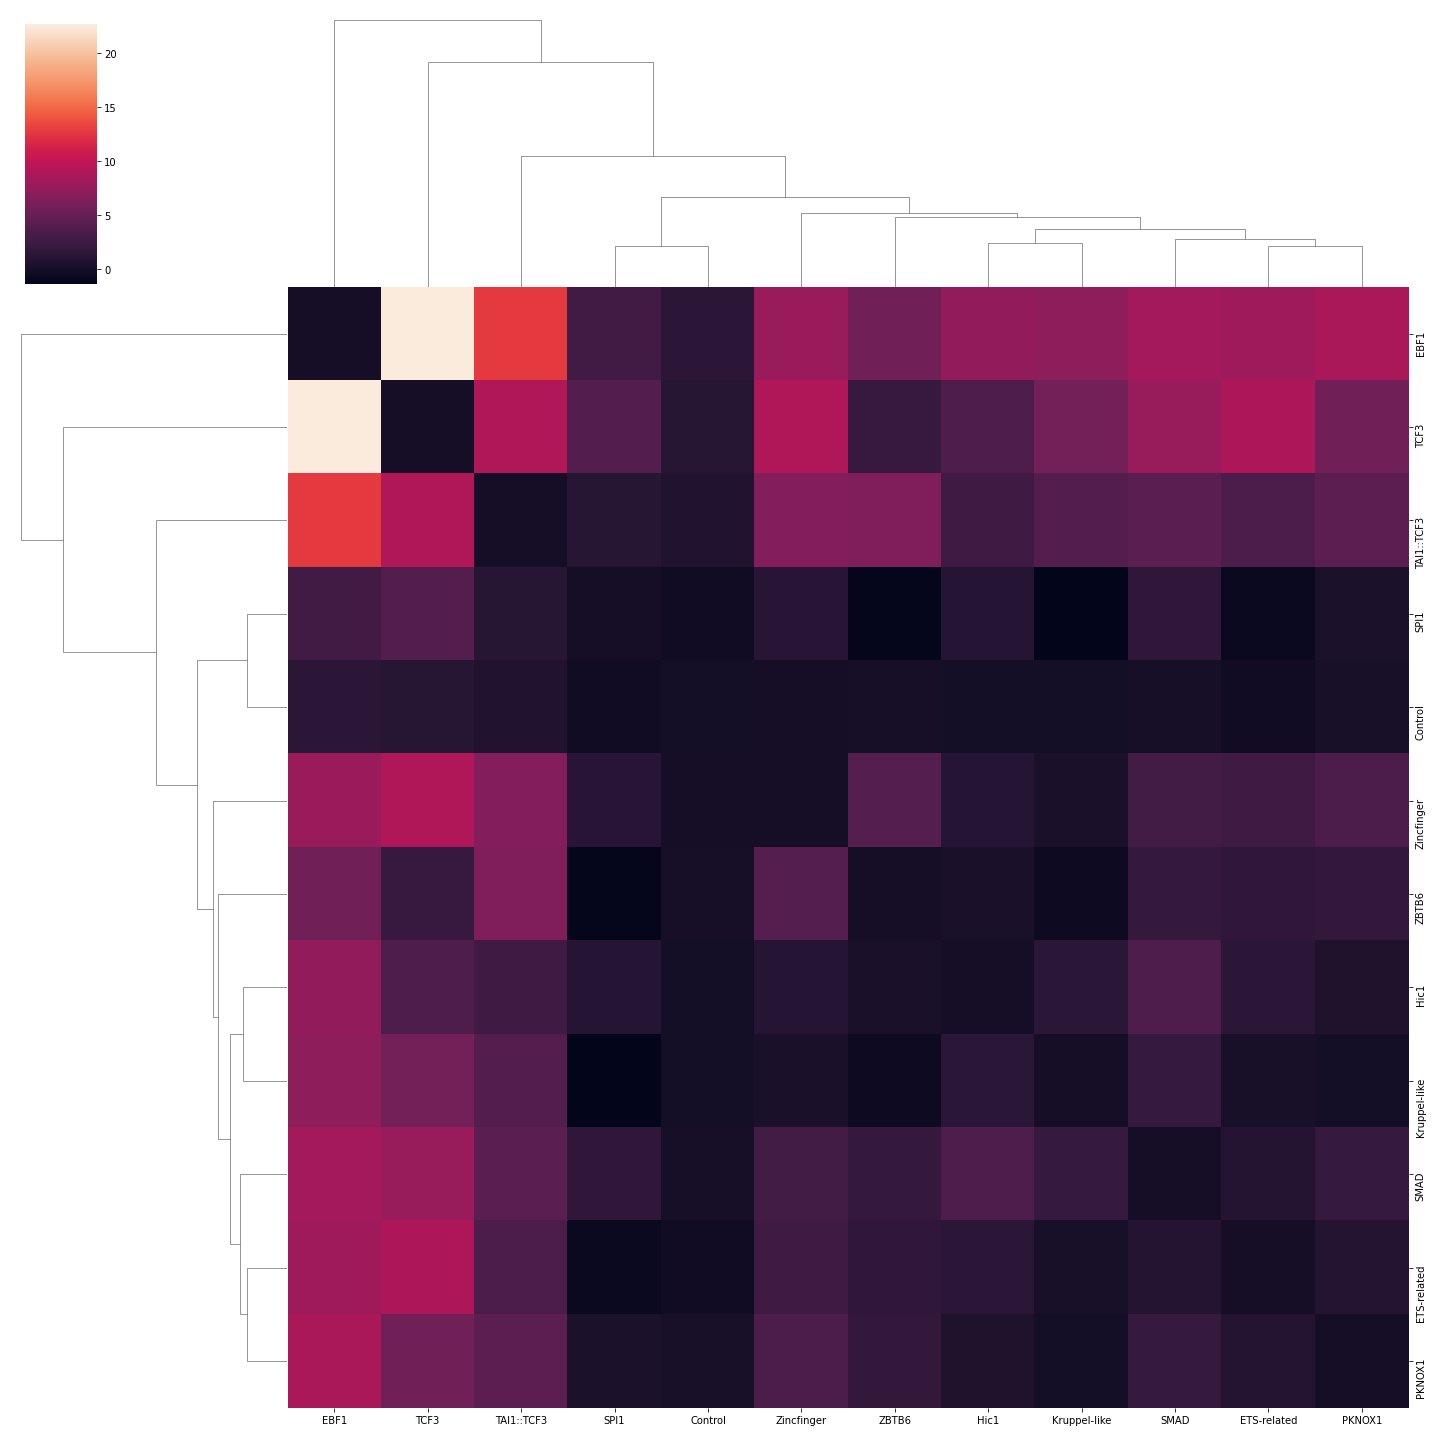

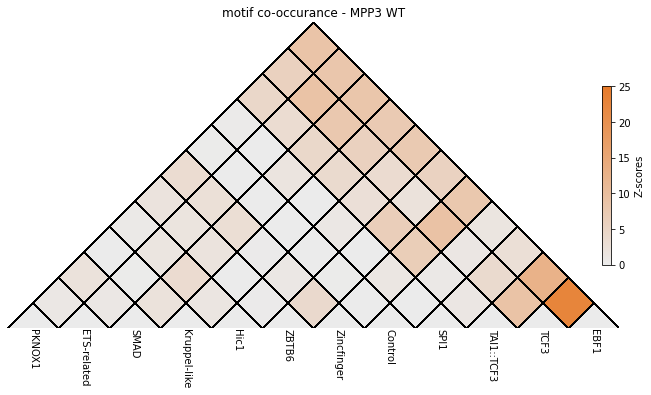

In [45]:
#MPP3WT [EBF_AL env]

MPP3WT_comot = pd.read_csv("../../data/ATAC/coMotifEnrichment_PU1/MPP3WT/MPP3WT_allMotsZscores.tsv",
                          sep='\t', index_col=0)
MPP3WT_comot = comotDFRenamer(MPP3WT_comot, motNameDic, 'MPP3WT')
# Collapse the controls with medians:
MPP3WT_comot = reducemotDF(MPP3WT_comot, 'MPP3WT')
# Filter those motifs if no interactions are above 2 (z-score):
ser = (MPP3WT_comot > 2).any(axis=1)
keepLis = list( ser[ser == True].index )
#Add the control in any case.
if 'Control' not in keepLis:
    keepLis.append('Control')

MPP3WT_comot_red = MPP3WT_comot[keepLis]
MPP3WT_comot_red = MPP3WT_comot_red.loc[keepLis,:]

# Get clusterorder.
g = sns.clustermap(MPP3WT_comot_red, figsize=(20,20), xticklabels=True, yticklabels=True)
rowClus = []
colClus = []
for index in g.dendrogram_row.reordered_ind:
    rowClus.append(MPP3WT_comot_red.index[index])
MPP3WT_comot_red = MPP3WT_comot_red.reindex( rowClus )

for index in g.dendrogram_col.reordered_ind:
    colClus.append(MPP3WT_comot_red.columns[index])
MPP3WT_comot_red = MPP3WT_comot_red.reindex(columns = colClus)

X, Y, C = retTriangCoords(MPP3WT_comot_red)
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(211, frame_on=False, aspect=2.0)
ax.set_xticks([])
ax.set_yticks([])
g = plt.pcolormesh(X,Y,np.flip(C), axes=ax, edgecolors='black',linewidth=0.75,
                   cmap = cmapFromHexLis( ['#ECECEC', "#E87B2A"] ),
                   norm = mp.colors.TwoSlopeNorm(vmin=0, vcenter=12.5, vmax=25))
ax.set_ylim(bottom=6)
ax.set_title("motif co-occurance - MPP3 WT")
ax.set_axisbelow(True)
plt.colorbar(g, orientation='vertical', shrink=0.5825,
             fraction=0.05, pad=-0.025, use_gridspec=True, label="Z-scores"
            )
fig.subplots_adjust(wspace=-0.12, hspace=0, left=0, right=1)
for i in list(range(-11,12,2)):
    plt.text(i, 6, list(MPP3WT_comot_red.index)[::-1][int( (i+11)/2 )] ,
             rotation=-90, va='top',ha='center')
plt.tight_layout()
plt.savefig("../../figures_OE/MPP3WT_comots_PU1.svg", dpi=300)

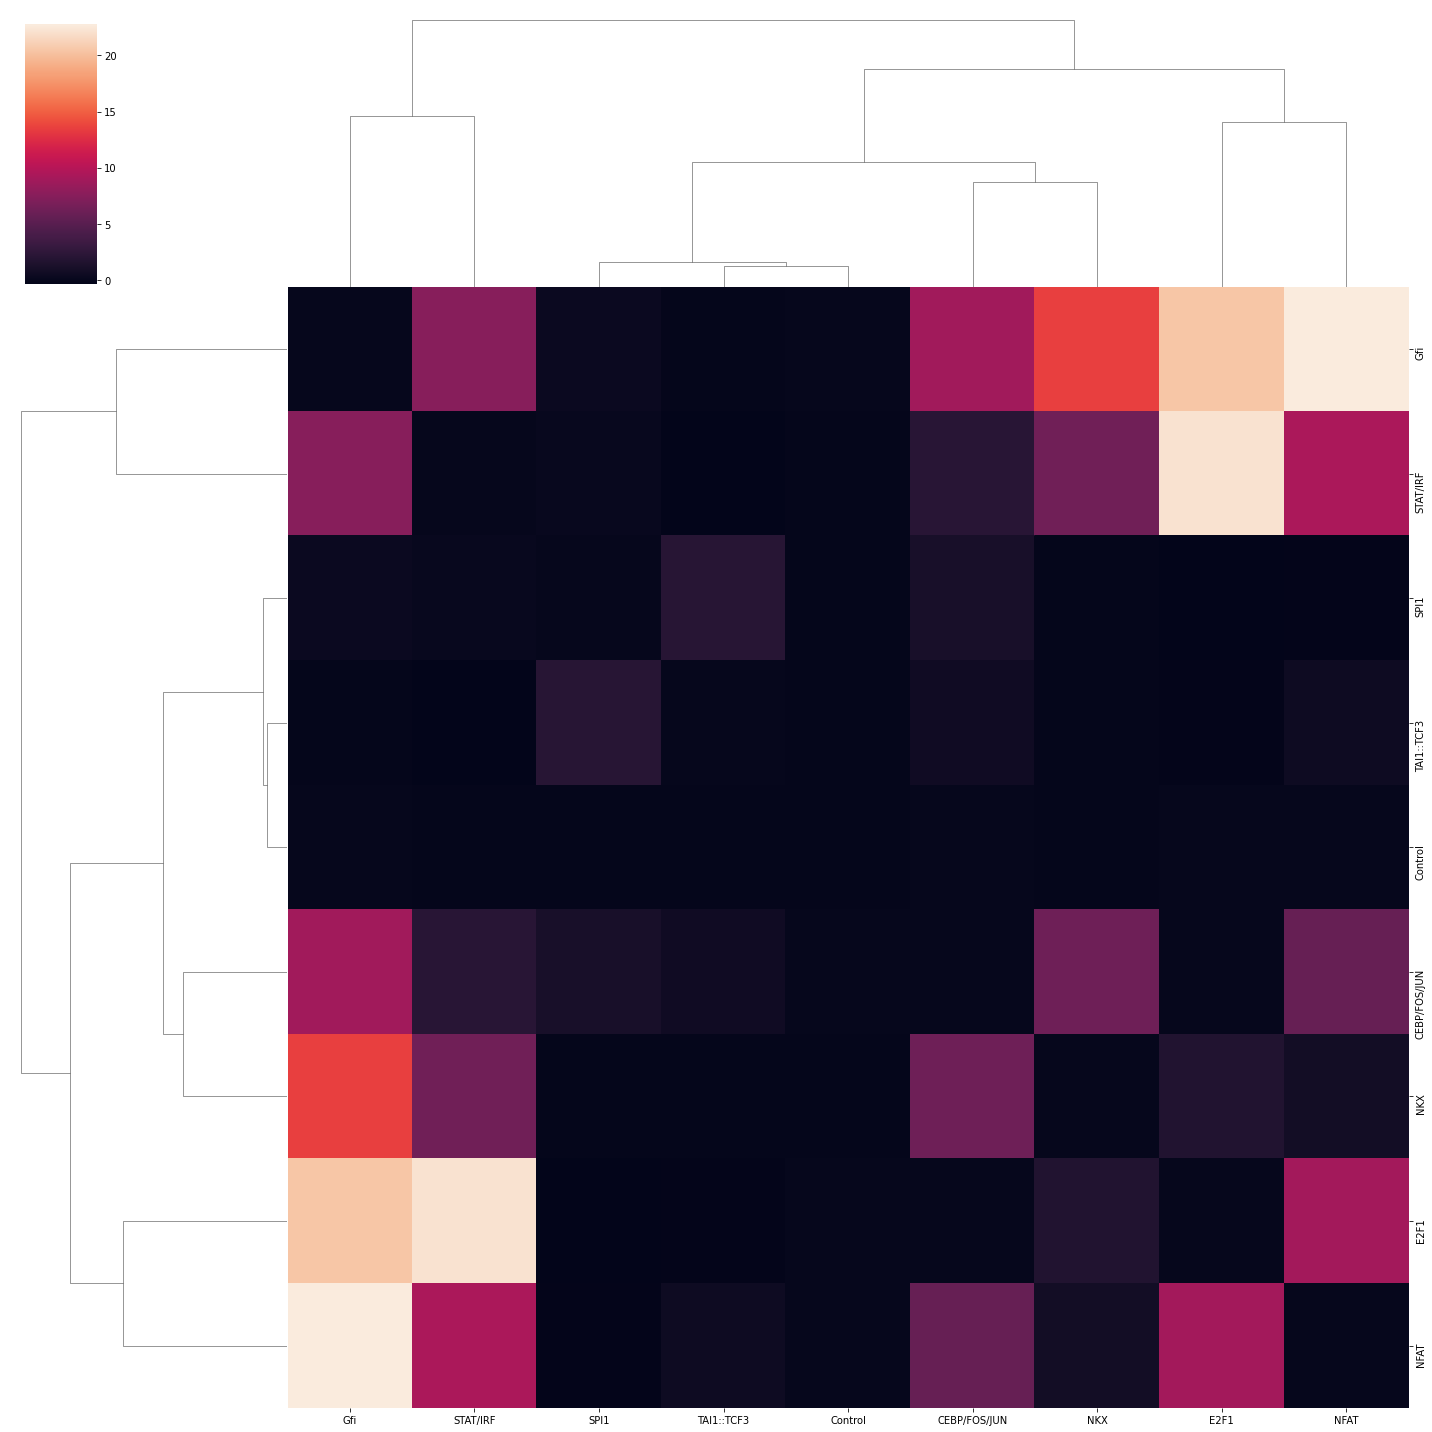

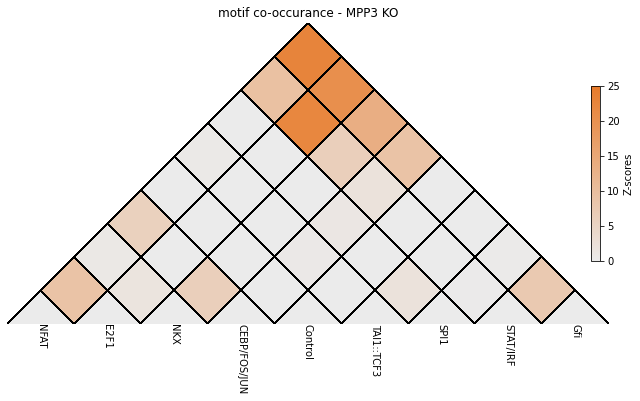

In [46]:
# MPP3 KO [EBF_AL env]

MPP3KO_comot = pd.read_csv("../../data/ATAC/coMotifEnrichment_PU1/MPP3KO/MPP3KO_allMotsZscores.tsv",
                          sep='\t', index_col=0)
MPP3KO_comot = comotDFRenamer(MPP3KO_comot, motNameDic, 'MPP3KO')
# Collapse the controls with medians:
MPP3KO_comot = reducemotDF(MPP3KO_comot, 'MPP3KO')
# Filter those motifs if no interactions are above 2 (z-score):

ser = (MPP3KO_comot > 2).any(axis=1)
keepLis = list( ser[ser == True].index )
#Add the control in any case.
if 'Control' not in keepLis:
    keepLis.append('Control')

MPP3KO_comot_red = MPP3KO_comot[keepLis]
MPP3KO_comot_red = MPP3KO_comot_red.loc[keepLis,:]

# Get clusterorder.
g = sns.clustermap(MPP3KO_comot_red, figsize=(20,20), xticklabels=True, yticklabels=True)
rowClus = []
colClus = []
for index in g.dendrogram_row.reordered_ind:
    rowClus.append(MPP3KO_comot_red.index[index])
MPP3KO_comot_red = MPP3KO_comot_red.reindex( rowClus )

for index in g.dendrogram_col.reordered_ind:
    colClus.append(MPP3KO_comot_red.columns[index])
MPP3KO_comot_red = MPP3KO_comot_red.reindex(columns = colClus)


X, Y, C = retTriangCoords(MPP3KO_comot_red)
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(211, frame_on=False, aspect=2.0)
ax.set_xticks([])
ax.set_yticks([])
g = plt.pcolormesh(X,Y,np.flip(C), axes=ax, edgecolors='black',linewidth=0.75,
                   cmap = cmapFromHexLis( ['#ECECEC', "#E87B2A"] ),
                   norm = mp.colors.TwoSlopeNorm(vmin=0, vcenter=12.5, vmax=25))
ax.set_ylim(bottom=4.5)
#ax.set_xlim(-21,21)
ax.set_title("motif co-occurance - MPP3 KO")
ax.set_axisbelow(True)
plt.colorbar(g, orientation='vertical', shrink=0.5825,
             fraction=0.05, pad=-0.025, use_gridspec=True, label="Z-scores"
            )
fig.subplots_adjust(wspace=-0.12, hspace=0, left=0, right=1)
for i in list(range(-8,9,2)):
    plt.text(i, 4.5, list(MPP3KO_comot_red.index)[::-1][int( (i+8)/2 )] ,
             rotation=-90, va='top',ha='center')
plt.tight_layout()
plt.savefig("../../figures_OE/MPP3KO_comots_PU1.svg", dpi=300)

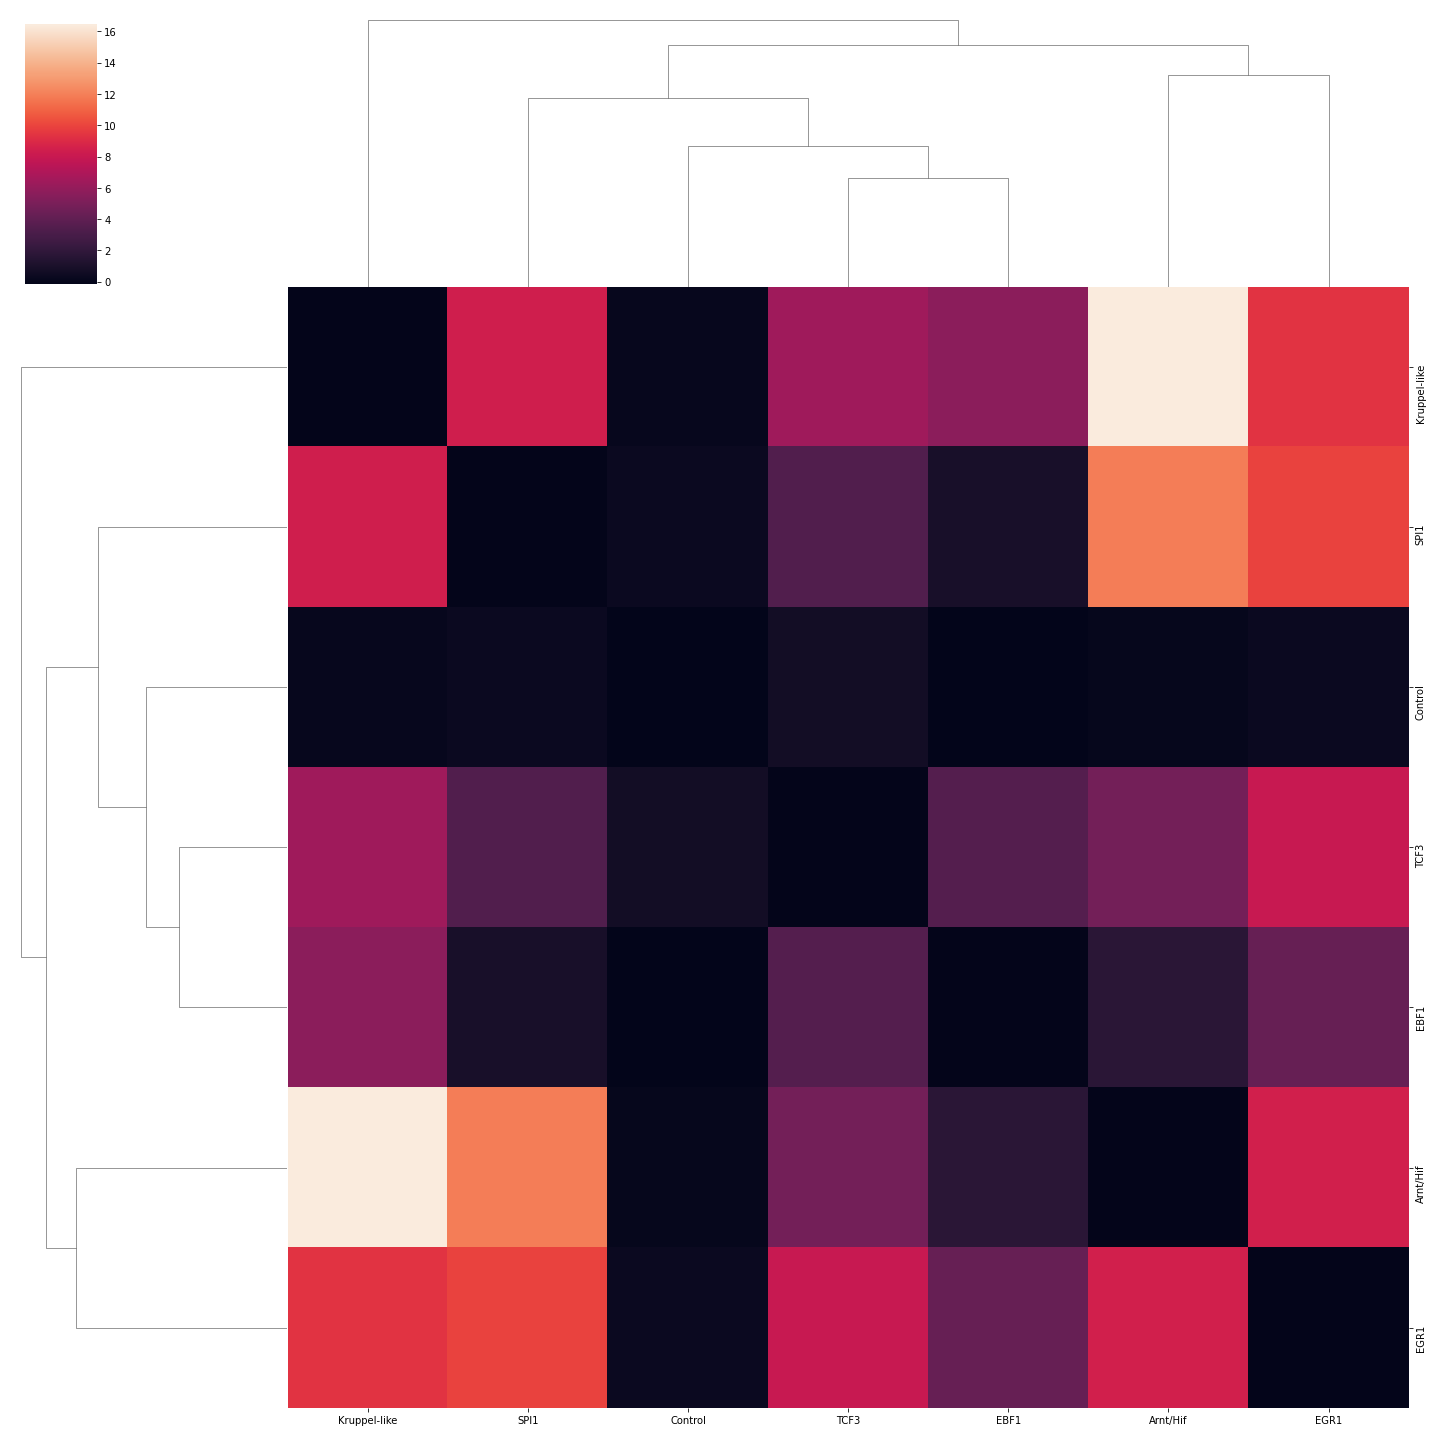

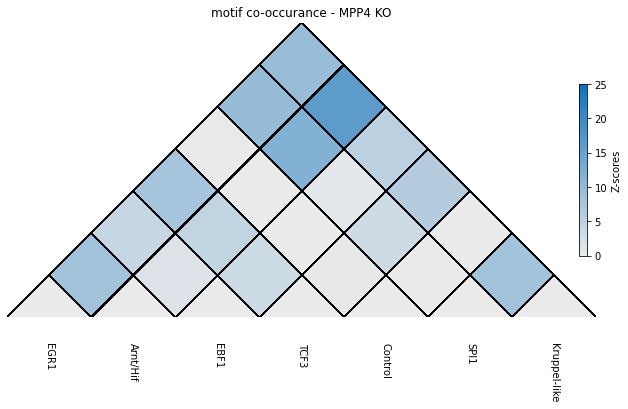

In [47]:
# MPP4 KO [EBF_AL env]

MPP4KO_comot = pd.read_csv("../../data/ATAC/coMotifEnrichment_PU1/MPP4KO/MPP4KO_allMotsZscores.tsv",
                          sep='\t', index_col=0)
MPP4KO_comot = comotDFRenamer(MPP4KO_comot, motNameDic, 'MPP4KO')
# Collapse the controls with medians:
MPP4KO_comot = reducemotDF(MPP4KO_comot, 'MPP4KO')

# Filter those motifs if no interactions are above 2 (z-score):

ser = (MPP4KO_comot > 2).any(axis=1)
keepLis = list( ser[ser == True].index )
#Add the control in any case.
if 'Control' not in keepLis:
    keepLis.append('Control')
    
MPP4KO_comot_red = MPP4KO_comot[keepLis]
MPP4KO_comot_red = MPP4KO_comot_red.loc[keepLis,:]

# Get clusterorder.
g = sns.clustermap(MPP4KO_comot_red, figsize=(20,20), xticklabels=True, yticklabels=True)
rowClus = []
colClus = []
for index in g.dendrogram_row.reordered_ind:
    rowClus.append(MPP4KO_comot_red.index[index])
MPP4KO_comot_red = MPP4KO_comot_red.reindex( rowClus )

for index in g.dendrogram_col.reordered_ind:
    colClus.append(MPP4KO_comot_red.columns[index])
MPP4KO_comot_red = MPP4KO_comot_red.reindex(columns = colClus)

X, Y, C = retTriangCoords(MPP4KO_comot_red)
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(211, frame_on=False, aspect=2.0)
ax.set_xticks(range(-20,20,1))
ax.set_yticks([])
ax.set_xticks([])
g = plt.pcolormesh(X,Y,np.flip(C), axes=ax, edgecolors='black',linewidth=0.75,
                   cmap = cmapFromHexLis( ['#ECECEC', "#1272BA"] ),
                   norm = mp.colors.TwoSlopeNorm(vmin=0, vcenter=12.5, vmax=25))
ax.set_ylim(bottom=3.5)
#ax.set_xlim(-7,7)
ax.set_title("motif co-occurance - MPP4 KO")
ax.set_axisbelow(True)
plt.colorbar(g, orientation='vertical', shrink=0.5825,
             fraction=0.05, pad=-0.025, use_gridspec=True, label="Z-scores"
            )

fig.subplots_adjust(wspace=-0.12, hspace=0, left=0, right=1)
for i in list(range(-6,7,2)):
    plt.text(i, 3.2, list(MPP4KO_comot_red.index)[::-1][int( (i+6)/2 )] ,
             rotation=-90, va='top',ha='center')
plt.tight_layout()
plt.savefig("../../figures_OE/MPP4KO_comots_PU1.svg", dpi=300)

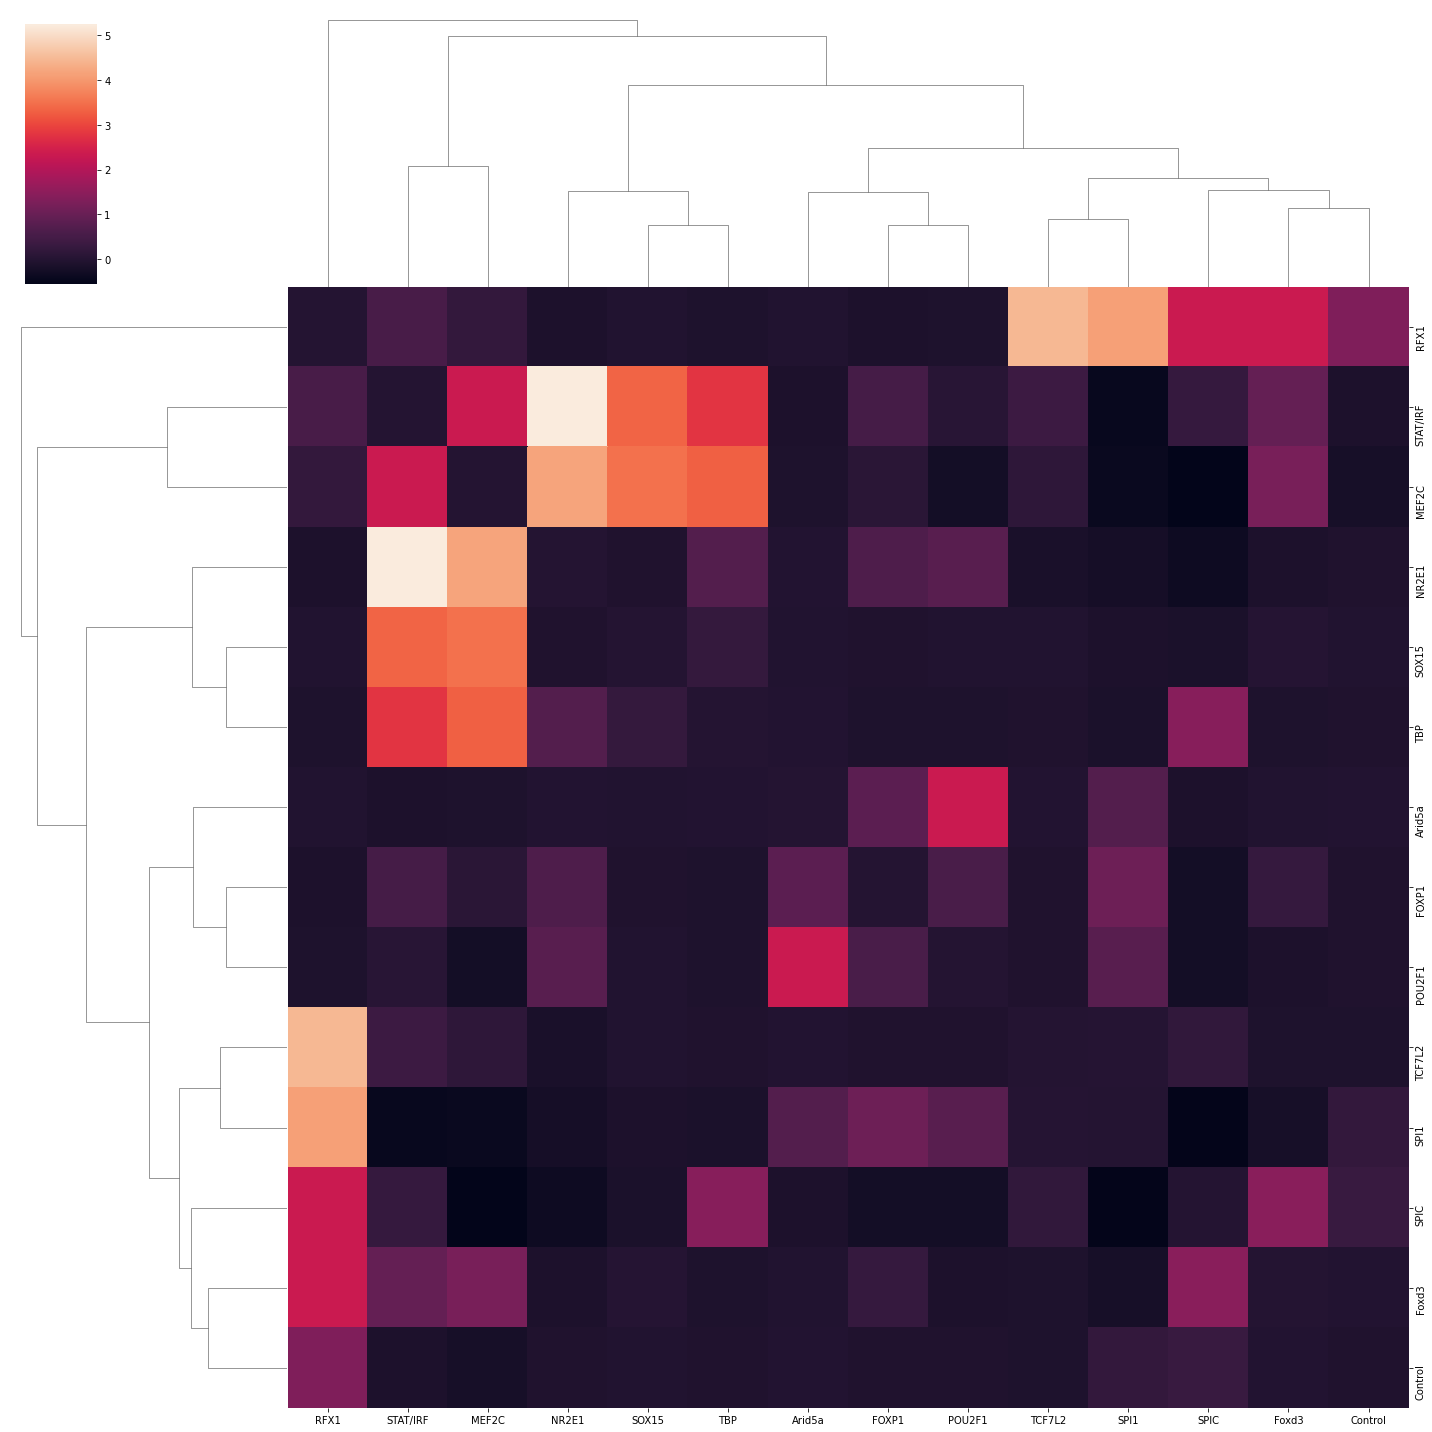

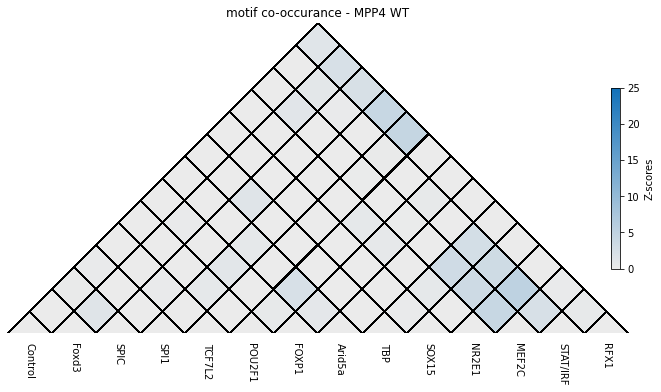

In [48]:
# MPP4 WT [EBF_AL env]

MPP4WT_comot = pd.read_csv("../../data/ATAC/coMotifEnrichment_PU1/MPP4WT/MPP4WT_allMotsZscores.tsv",
                          sep='\t', index_col=0)
MPP4WT_comot = comotDFRenamer(MPP4WT_comot, motNameDic, 'MPP4WT')

# Collapse the controls with medians:
MPP4WT_comot = reducemotDF(MPP4WT_comot, 'MPP4WT')
# Filter those motifs if no interactions are above 2 (z-score):

ser = (MPP4WT_comot > 2).any(axis=1)
keepLis = list( ser[ser == True].index )
#Add the control in any case.
if 'Control' not in keepLis:
    keepLis.append('Control')

#! Foxp3 and Foxp1 clusters are very similar
# They are missed in the clustering round because in round 1 Foxp3 has 4 additional positions.
if 'FOXP3' in keepLis:
    keepLis.remove("FOXP3")
    
MPP4WT_comot_red = MPP4WT_comot[keepLis]
MPP4WT_comot_red = MPP4WT_comot_red.loc[keepLis,:]

# Get clusterorder.
g = sns.clustermap(MPP4WT_comot_red, figsize=(20,20), xticklabels=True, yticklabels=True)
rowClus = []
colClus = []
for index in g.dendrogram_row.reordered_ind:
    rowClus.append(MPP4WT_comot_red.index[index])
MPP4WT_comot_red = MPP4WT_comot_red.reindex( rowClus )

for index in g.dendrogram_col.reordered_ind:
    colClus.append(MPP4WT_comot_red.columns[index])
MPP4WT_comot_red = MPP4WT_comot_red.reindex(columns = colClus)


X, Y, C = retTriangCoords(MPP4WT_comot_red)
fig = plt.figure(figsize=(10,10))

ax = fig.add_subplot(211, frame_on=False, aspect=2.0)
ax.set_xticks(range(-20,20,1))
ax.set_yticks([])
ax.set_xticks([])
g = plt.pcolormesh(X,Y,np.flip(C), axes=ax, edgecolors='black',linewidth=0.75,
                   cmap = cmapFromHexLis( ['#ECECEC', "#1272BA"] ),
                   norm = mp.colors.TwoSlopeNorm(vmin=0, vcenter=12.5, vmax=25))
ax.set_ylim(bottom=7)Cluster_14 MPP3KO_Cl6,MPP4WT_Cl22
ax.set_title("motif co-occurance - MPP4 WT")
ax.set_axisbelow(True)
plt.colorbar(g, orientation='vertical', shrink=0.5825,
             fraction=0.05, pad=-0.025, use_gridspec=True, label="Z-scores"
            )
fig.subplots_adjust(wspace=-0.12, hspace=0, left=0, right=1)
for i in list(range(-13,14,2)):
    plt.text(i, 6.8, list(MPP4WT_comot_red.index)[::-1][int( (i+13)/2 )] ,
             rotation=-90, va='top',ha='center')
plt.tight_layout()
plt.savefig("../../figures_OE/MPP4WT_comots_PU1.svg", dpi=300)

### Aggregation plots.


We want to have a look at SPI1 in 3 different sites:
 - LTHSC peaks
 - MPP3 peaks
 - MPP4 peaks
 
We take a similar approach with fimo / tobias & 

To do this we run fimo:

[EBF_AL env]
run fimo on MPP3 WT-specific peaks for EBF motif.

For EBF1:

```bash
fimo --max-stored-scores 100000000 --o ../../data/ATAC/TOBIAS/EBF_MPP3WT ../../LFS/genomeData/singleMotifs/EBF1_MA0154.3.meme ../../data/ATAC/output/MPP3_WT.fna

python ../scripts/fimoCentral.py -i ../../data/ATAC/TOBIAS/EBF_MPP3WT/fimo.tsv -o ../../data/ATAC/TOBIAS/EBF_MPP3WT/ --cond EBF1hits_MPP3WT
```

[TOBIASenv]  
```bash
TOBIAS PlotAggregate --TFBS ../../data/ATAC/TOBIAS/EBF_MPP3WT/MA0154.3.EBF1hits_MPP3WT.bed --signals ../../LFS/TOBIAS/MPP3_WT_corrected.bw ../../LFS/TOBIAS/MPP3_KO_corrected.bw ../../LFS/TOBIAS/MPP4_WT_corrected.bw ../../LFS/TOBIAS/MPP4_KO_corrected.bw --output ../../data/ATAC/TOBIAS/EBFhitMPP3WT_aggPlot.pdf --output-txt ../../data/ATAC/TOBIAS/EBFhitMPP3WT_aggPlot.txt --share-y signals --signal-on-x --smooth 5 --plot-boundaries
```

[EBF_AL env]  

Look for CTCF sites.
```bash
fimo --max-stored-scores 100000000 --o ../../data/ATAC/TOBIAS/CTCF_MPP3 ../../LFS/genomeData/singleMotifs/CTCF_MA0139.1.meme ../../data/ATAC/output/MPP3_peaks.fna

python ../scripts/fimoCentral.py -i ../../data/ATAC/TOBIAS/CTCF_MPP3/fimo.tsv -o ../../data/ATAC/TOBIAS/CTCF_MPP3/ --cond CTCFhits_MPP3
```

Take random subset of all CTCF sites to have an equal number of sites as for EBF (336):

```bash
python ../scripts/randomBed.py -i ../../data/ATAC/TOBIAS/CTCF_MPP3/MA0139.1.CTCFhits_MPP3.bed -o ../../data/ATAC/TOBIAS/CTCF_MPP3/CTCFsites_subset -l 336 -n 100
```

[TOBIASenv]
```bash
TOBIAS PlotAggregate --TFBS ../../data/ATAC/TOBIAS/CTCF_MPP3/CTCFsites_subset/*bed --signals ../../LFS/TOBIAS/MPP3_WT_corrected.bw ../../LFS/TOBIAS/MPP3_KO_corrected.bw ../../LFS/TOBIAS/MPP4_WT_corrected.bw ../../LFS/TOBIAS/MPP4_KO_corrected.bw --output ../../data/ATAC/TOBIAS/CTCFhitMPP3subset_aggPlot.pdf --output-txt ../../data/ATAC/TOBIAS/CTCFhitMPP3subset_aggPlot.txt --share-y signals --signal-on-x --smooth 5 --plot-boundaries
```